In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse,aic

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
r=pd.read_csv("/content/drive/My Drive/stock/final_RELIANCE.NS.csv")
nt=pd.read_csv("/content/drive/My Drive/tone/pct730/pct730_Reliance.csv")
df=pd.DataFrame()
df['return']=r['return']
df['negative tone']=nt['PCT']
df['Date']=r['Date']
df.set_index('Date',inplace=True)
df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
df.replace([np.inf, -np.inf], np.nan)

df.dropna(inplace=True)
df



,return,negative tone
Date,,
2018-01-01,0.00,1.19
2018-01-02,0.15,1.23
2018-01-03,0.40,0.76
2018-01-04,0.60,1.37
2018-01-05,0.32,1.33
...,...,...
2019-12-27,-0.25,0.98
2019-12-28,0.00,2.36
2019-12-29,0.00,0.65


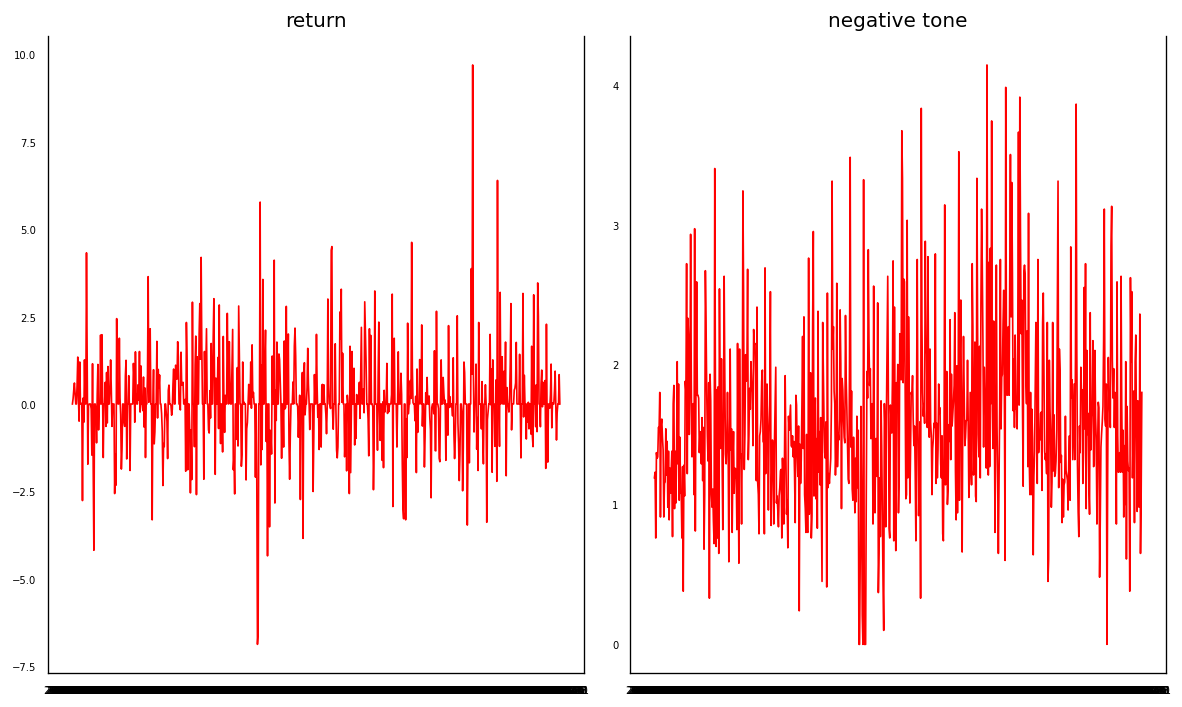

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,return_x,negative tone_x
return_y,1.0000,0.0996
negative tone_y,0.3782,1.0000


In [ ]:
# Results from Granger Casuality test can be read as : negative tone causes return (10% significance) but return do not causes negative tone.


In [ ]:
t = 5
df_train, df_test = df[0:-t], df[-t:]

# Check size
print(df_train.shape)  # (655, 2)
print(df_test.shape)  # (73, 2)


(723, 2)
(5, 2)


In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [ ]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.1195
 No. Lags Chosen       = 7
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "negative tone" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9229
 No. Lags Chosen       = 16
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [ ]:
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')
print(df_train[-t:])   

Lag Order = 1
AIC :  -0.2408645913380177
BIC :  -0.2027868201006812
FPE :  0.7859481185339715
HQIC:  -0.22616637854267047 

Lag Order = 2
AIC :  -0.23538560086994442
BIC :  -0.17185385139303805
FPE :  0.7902664150099995
HQIC:  -0.21086044486589256 

Lag Order = 3
AIC :  -0.23983380339314705
BIC :  -0.15079280760406175
FPE :  0.786759570867269
HQIC:  -0.20545910012056615 

Lag Order = 4
AIC :  -0.23208068109017854
BIC :  -0.1174749725519604
FPE :  0.7928842237519493
HQIC:  -0.18783374346597947 

Lag Order = 5
AIC :  -0.2281600182964749
BIC :  -0.08793393122257387
FPE :  0.7960006925347057
HQIC:  -0.1740180757973667 

Lag Order = 6
AIC :  -0.2186381451318042
BIC :  -0.05273581339457947
FPE :  0.8036188443403199
HQIC:  -0.15457834337470294 

Lag Order = 7
AIC :  -0.24649994641831036
BIC :  -0.05486530255124422
FPE :  0.7815409871948273
HQIC:  -0.1724993467380733 

Lag Order = 8
AIC :  -0.23985444263645034
BIC :  -0.022431216830022027
FPE :  0.7867564731650046
HQIC:  -0.15589002166091495 


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-0.1946,-0.1818*,0.8231,-0.1897
1,-0.2173,-0.1788,0.8047,-0.2024*
2,-0.2141,-0.1498,0.8073,-0.1892
3,-0.2191,-0.1292,0.8032,-0.1844
4,-0.2140,-0.09837,0.8074,-0.1693
5,-0.2127,-0.07140,0.8084,-0.1581
6,-0.2059,-0.03889,0.8139,-0.1414
7,-0.2362*,-0.04352,0.7896*,-0.1618
8,-0.2323,-0.01394,0.7927,-0.1480
9,-0.2234,0.02062,0.7998,-0.1292


In [ ]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Jan, 2021
Time:                     13:36:21
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                 -0.0548653
Nobs:                     716.000    HQIC:                 -0.172499
Log likelihood:          -1913.67    FPE:                   0.781541
AIC:                    -0.246500    Det(Omega_mle):        0.749796
--------------------------------------------------------------------
Results for equation return
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.572350         0.264714            2.162           0.031
L1.return                0.069383         0.037509            1.850           0.064
L1.negative tone        -0.114536         0.080

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

return : 2.02
negative tone : 2.01


In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #1

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

7


array([[ 0.03,  0.87],
       [ 0.  ,  2.02],
       [ 0.  ,  2.21],
       [ 0.37,  1.5 ],
       [ 0.94,  0.95],
       [ 0.  ,  1.74],
       [-1.03,  1.18]])

In [ ]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=t)

df_forecast = pd.DataFrame(fc, index=df.index[-t:], columns=df.columns)
df_forecast

,return,negative tone
Date,,
2019-12-27,-0.061392,1.394765
2019-12-28,-0.016085,1.639964
2019-12-29,0.164812,1.667223
2019-12-30,0.115456,1.571197
2019-12-31,0.064668,1.469143


In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr})

print('Forecast Accuracy of: return')
accuracy_prod = forecast_accuracy(df_forecast['return'].values, df_test['return'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: negative tone')
accuracy_prod = forecast_accuracy(df_forecast['negative tone'].values, df_test['negative tone'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))



Forecast Accuracy of: return
mape :  inf
me :  -0.0645
mae :  0.2317
mpe :  nan
rmse :  0.3441
corr :  0.5211

Forecast Accuracy of: negative tone
mape :  0.5864
me :  0.1745
mae :  0.5948
mpe :  0.3908
rmse :  0.6444
corr :  0.0763
